In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('datasets/pavement-conditions.csv', delimiter=';')
print(f"df shape: {df.shape}")
print(f"Total number of samples: {len(df)}")

df shape: (5404, 8)
Total number of samples: 5404


In [25]:
from sklearn.preprocessing import LabelEncoder

# select relevant features
# turn PCI Rating into numerical values
le = LabelEncoder()
df["PCI Rating Encoded"] = le.fit_transform(df["PCI Rating"])

# # turn geo_point_2d into string
# df["geo_point_2d"] = df["geo_point_2d"].astype(str)
# # split geo_point_2d into Latitude and Longitude columns
# df[["Latitude", "Longitude"]] = df["geo_point_2d"].str.split(",", expand=True).astype(float)

# feature matrix
features = ["length_(m)", "PCI Rating Encoded"]
# features = ["length_(m)", "PCI Rating Encoded", "Latitude", "Longitude"]
X = df[features]

# scale features because we are using distance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

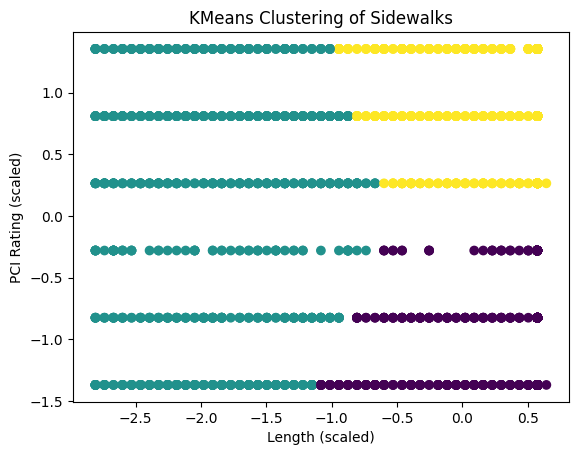

In [27]:
import matplotlib.pyplot as plt

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df["Cluster"], cmap="viridis")
plt.xlabel("Length (scaled)")
plt.ylabel("PCI Rating (scaled)")
plt.title("KMeans Clustering of Sidewalks")
plt.show()

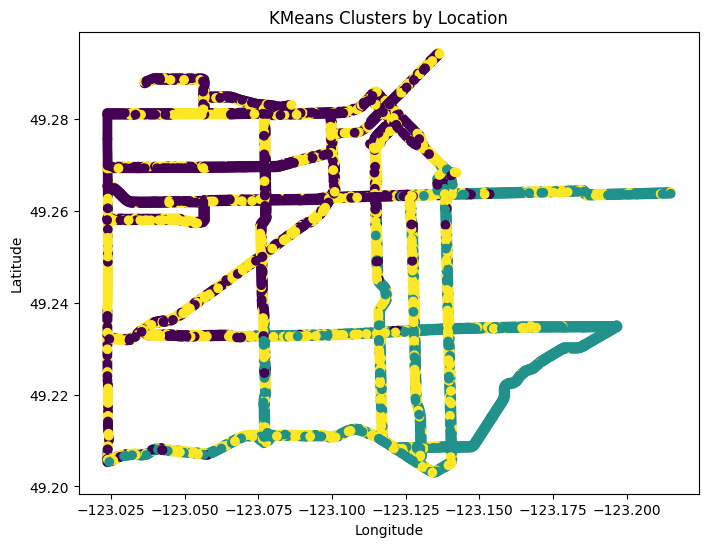

In [ ]:
# IF USING LOCATION

plt.figure(figsize=(8, 6))
plt.scatter(df["Longitude"], df["Latitude"], c=df["Cluster"], cmap="viridis")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clusters by Location")
plt.gca().invert_xaxis()  # Optional: west is left
plt.show()

## Visualizing Bottleneck Feature Representations

We can visualize the bottleneck representations of data points with a 2D scatter plot.

The `scatter_plot` function takes the following arguments:
* latent_presentations - (N, dimension_latent_representation) numpy array
* labels - (N, ) numpy array: the labels of predicted cluster or None

In [28]:
with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]

    for x in trainer.val_loader:
        x = x.view(x.size(0),-1)
        z_ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
    z = np.asarray(z)


from autoencoder_starter import scatter_plot
scatter_plot(latent_representations=z,labels=None) # You can use your cluster labels heere.

NameError: name 'torch' is not defined

## Find the optimum number of clusters
### Elbow Evaluation

In [ ]:
# Needs your implementation
# used code from geeksforgeeks https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store distortion and inertia values
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
  kmeanModel = KMeans(n_clusters=k, random_state=42).fit(z)

  # Calculate distortion as the average squared distance from points to their cluster centers
  distortions.append(sum(np.min(cdist(z, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / z.shape[0])

  # Inertia is calculated directly by KMeans
  inertias.append(kmeanModel.inertia_)

  # Store the mappings for easy access
  mapping1[k] = distortions[-1]
  mapping2[k] = inertias[-1]

print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')
# Plotting the graph of k versus Distortion
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.grid()
plt.show()

print("Inertia values:")
for key, val in mapping2.items():
    print(f'{key} : {val}')
# Plotting the graph of k versus Inertia
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.grid()
plt.show()

### Silhouette score analysis

In [ ]:
# Needs your implementation

# used code from Selecting the number of clusters with silhouette analysis on KMeans clustering example
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [3]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(z) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(z)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(z, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(z, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

## Cluster and visualize

In [ ]:
# Needs your implementation
# used code from geeksforgeeks https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

from autoencoder_starter import scatter_plot
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(z)

scatter_plot(latent_representations=z,labels=y_kmeans) # You can use your cluster labels heere.

# Clustering with K-Means

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X_scaled)

df["kmeans_cluster"] = clusters

In [ ]:
sns.scatterplot(data=df, x="pca1", y="pca2", hue="kmeans_cluster", palette="Set2")
plt.title("K-Means Clusters in PCA Space")

In [ ]:
sns.scatterplot(data=df, x="pca1", y="pca2", hue="diagnosis", palette="Set1")
plt.title("True Diagnoses in PCA Space")